The purpose of this code is to quantify the size and number of synuclein inclusions for each image.

Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk
import czifile
import skimage.io as io
from skimage import exposure
from cellpose import models
model = models.Cellpose(model_type='cyto')

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, 

Define Sub Functions

In [2]:
def show_image(image):
    io.imshow(image, cmap='gray')
    plt.show()

def preprocess_green_channel(green_channel):
    """Preprocess the green channel for cell segmentation and inclusion quantification."""
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())
    
    return confocal_img

def preprocess_dapi_channel(dapi_channel):
    """Preprocess the DAPI channel for nuclei quantification."""
    blurred_dapi = gaussian(dapi_channel, sigma=2)
    threshold_value = threshold_otsu(blurred_dapi)
    binary_image = blurred_dapi > threshold_value
    # show_image(binary_image)
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image

def count_nuclei(labeled_image):
    """Count the number of nuclei in the labeled image."""
    return len(np.unique(labeled_image)) - 1



In [3]:
def analyze_image(image_path, basename):
    """
    Analyze an image by its individual cells
    Args:
        image_path: Path to the .czi image file.
        basename: Base name for the file, used in the output DataFrame.

    Returns:
        A DataFrame containing details about each image 
        A second DataFrame containing details about each detected cell
    """
    
    # Load the image and squeeze dimensions
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)
    
    green_channel = np.squeeze(image)
    if (image_squeezed.ndim == 3):
        green_channel = image_squeezed[1]

    green_channel = preprocess_green_channel(green_channel)
    print("Green Channel")
    show_image(green_channel)


    # green_channel_remove_inclusions = np.where(green_channel < 0.8, green_channel, 0) # remove inclusions
    # green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=10) # blur

    # Detect cells in the green channel
    # masks, flows, styles, diams = model.eval(green_channel_remove_inclusions, diameter=300, channels=[0, 0])
    masks = green_channel > 0.05
    # exclude small objects
    masks = remove_small_objects(masks, min_size=100)
    labeled_cells = label(masks)
    # print number of cells
    print("Number of cells: ", len(np.unique(labeled_cells)) - 1)
    print("Segmented Cells")
    show_image(labeled_cells)


    # Initialize lists to store results
    cell_counter = []
    cell_size = []
    num_inclusions = []
    total_inclusion_areas = []
    average_inclusion_areas = []

    inclusion_areas_list = []
    inclusion_counter = []
    inclusion_counter_cells = []
    inclusions_image_list = []

    # Analyze each detected cell
    for i, cell in enumerate(regionprops(labeled_cells)):
        cell_counter.append(i)
        cell_size.append(cell.area)
        
        mask = labeled_cells == cell.label
        
        applied_mask_blurred = gaussian(green_channel, sigma=5) * mask
        applied_mask_eliminate_background = applied_mask_blurred[applied_mask_blurred > 0] # filter out 0
        
        # normalize 
        applied_mask_eliminate_background = (applied_mask_eliminate_background - np.min(applied_mask_eliminate_background)) / ((np.max(applied_mask_eliminate_background) - np.min(applied_mask_eliminate_background)))

        # calculate statistics
        mean_intensity = np.mean(applied_mask_eliminate_background)
        median_intensity = np.median(applied_mask_eliminate_background)
        q1 = np.percentile(applied_mask_eliminate_background, 25)
        q3 = np.percentile(applied_mask_eliminate_background, 75)
        
        hist, bin_edges = np.histogram(applied_mask_eliminate_background, bins='fd')
        
        applied_mask = green_channel * mask
        # 0.4 is an empirical value that seems to work well
        if q3 < 0.4 and len(bin_edges) > 20:
            # the population is skewed to the left, indicating that there are inclusions
            threshold = max(threshold_otsu(applied_mask),0.7) # use otsu thresholding to find the threshold
        elif q3 >= 0.9:
            # definitely no inclusions
            threshold = 1
        else:
            # probably no inclusions, but not sure, so we set a very high threshold in case there are inclusions
            threshold = 0.99
        
        inclusions = applied_mask > threshold # apply the threshold
        inclusions_labeled = label(inclusions)
        
        inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled) if inclusion.area > 10 and inclusion.area < 1500] # filter out inclusions that are too small or too large
        inclusion_areas = np.array(inclusion_areas)
        total_inclusion_area = np.sum(inclusion_areas)
        average_inclusion_area = np.mean(inclusion_areas)
        
        if len(inclusion_areas) > 0:
            # print("Threshold: ", threshold)
            # print("Bin count", len(bin_edges))

            # plt.hist(applied_mask_eliminate_background, bins='fd')  
            # plt.axvline(mean_intensity, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_intensity:.2f}')
            # plt.axvline(median_intensity, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_intensity:.2f}')
            # plt.axvline(q1, color='blue', linestyle='dashed', linewidth=2, label=f'Q1: {q1:.2f}')
            # plt.axvline(q3, color='purple', linestyle='dashed', linewidth=2, label=f'Q3: {q3:.2f}')
            # plt.legend()
            # plt.title("Intensity histogram")
            # plt.show()

            # print("Inclusion Areas: ", inclusion_areas)
            # show_image(inclusions)
            print(inclusion_areas)
            inclusions_image_list.append(inclusions)


            
        
        # store results
        total_inclusion_areas.append(total_inclusion_area)
        num_inclusions.append(len(inclusion_areas))
        inclusion_areas_list.append(inclusion_areas)
        inclusion_counter.append(range(len(inclusion_areas)))
        inclusion_counter_cells.append([i] * len(inclusion_areas))
        average_inclusion_areas.append(average_inclusion_area)
    
    # combine all inclusion images
    all_inclusions = np.sum(inclusions_image_list, axis=0)
    if len(inclusions_image_list) > 0:
        show_image(all_inclusions)
    # analysis by image
    df1 = pd.DataFrame({
        "File_Name:": [basename],
        "Number_of_Inclusions": [np.sum(num_inclusions)],
        "Number_of_Cells": [len(cell_counter)],
        "Average_Inclusion_Count": [np.sum(num_inclusions)/len(cell_counter)],
    })
    
    # analysis by cell
    df2 = pd.DataFrame({
        "File_Name": [basename] * len(cell_counter),
        "Cell": cell_counter,
        "Num_Inclusions": num_inclusions
    })
    
    # analysis by inclusion
    if len(inclusion_counter) == 0:
        df3 = pd.DataFrame()
    else:
        df3 = pd.DataFrame({
            "File_Name": [basename] * len(np.concatenate(inclusion_counter)),
            "Inclusion": np.concatenate(inclusion_counter),
            "Cell": np.concatenate(inclusion_counter_cells),
            "Inclusion_Area": np.concatenate(inclusion_areas_list)
        })

    
    return df1, df2, df3


In [4]:
def analyze_all_images(image_folder):
    all_data_1 = []
    all_data_2 = []
    all_data_3 = []
    for well_image in os.listdir(image_folder):
        
        if well_image.lower().endswith(".czi"):  # Filter for CZI files
            
            print(well_image)

            well_image_path = os.path.join(image_folder, well_image)
            well_image_base_name = os.path.basename(well_image)[:-4]
            
            df1, df2, df3 = analyze_image(well_image_path, well_image_base_name)
            all_data_1.append(df1)
            all_data_2.append(df2)
            all_data_3.append(df3)
            
            print("-" * 200)

    combined_df_1 = pd.concat(all_data_1, ignore_index=True)
    combined_df_1.to_excel(f"{image_folder[:6]}_analysis_by_image.xlsx", index=False)

    combined_df_2 = pd.concat(all_data_2, ignore_index=True)
    combined_df_2.to_excel(f"{image_folder[:6]}_analysis_by_cell.xlsx", index=False)

    combined_df_3 = pd.concat(all_data_3, ignore_index=True)
    combined_df_3.to_excel(f"{image_folder[:6]}_analysis_by_inclusion.xlsx", index=False)

Define Main Function

In [5]:
# folders = ['100424_1K_WT_3K_tiles/new settings','101124_1K_WT_3K_tiles','101824_1k_wt_3k_tiles','120624_1k_wt_3k_tiles','121324_1k_wt_3k_tiles']
folders = ['41125_1K_WT_3K_peroxidation']

1K_OA_erastin_01.czi
Green Channel


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


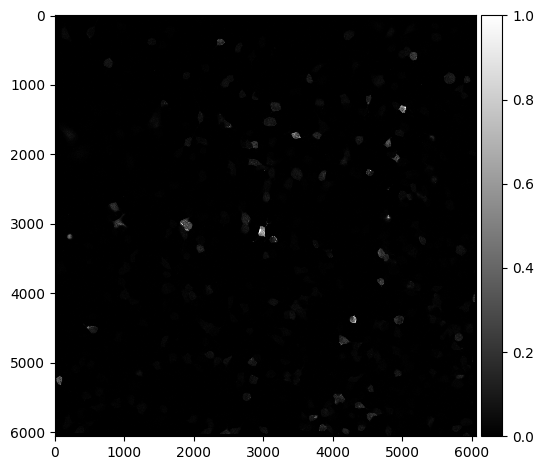

Number of cells:  113
Segmented Cells


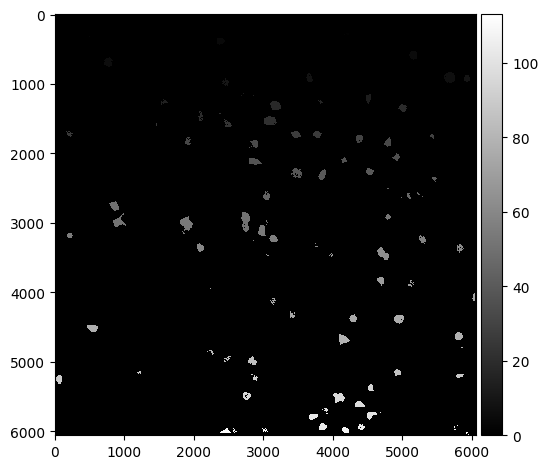

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[74. 40.]
[216.]
[32.]
[26.]


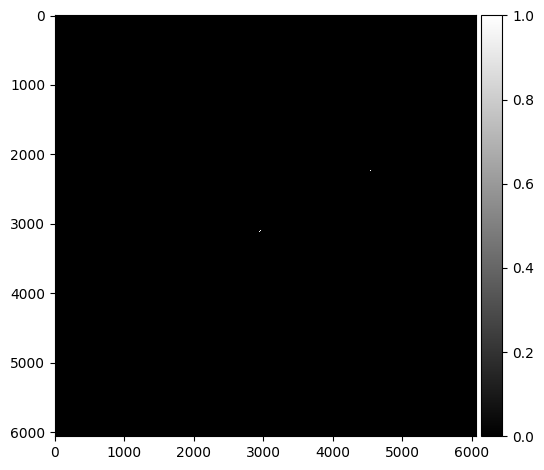

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_OA_erastin_02.czi
Green Channel


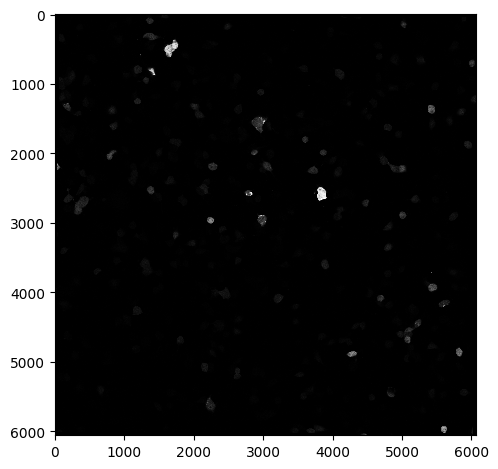

Number of cells:  98
Segmented Cells


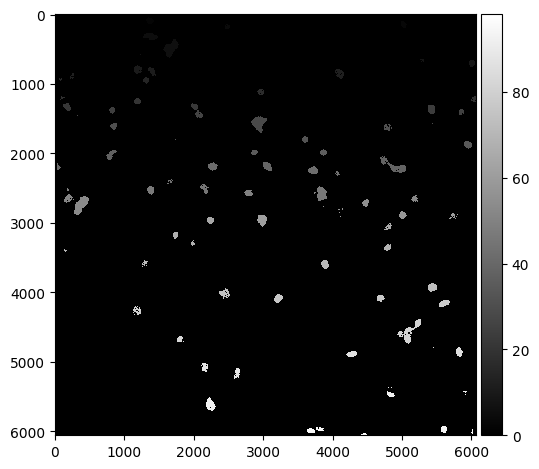

[ 21.  27.  11. 121.  54.  31.]
[325.  33.  14.  67.]


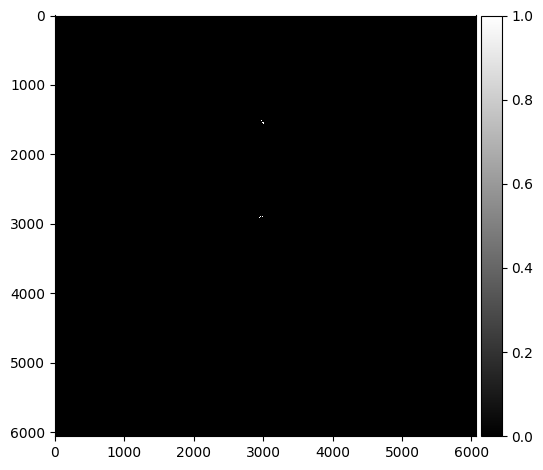

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_OA_FIN02_01.czi
Green Channel


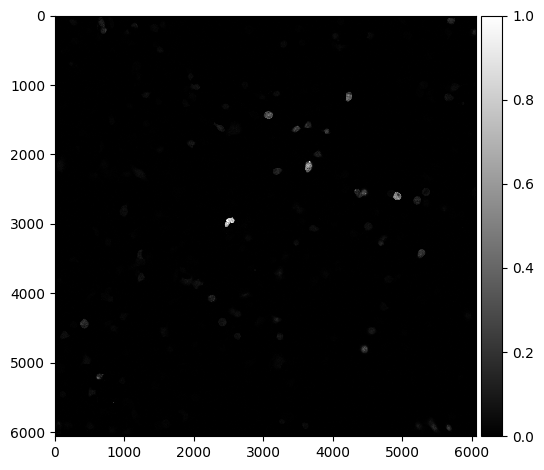

Number of cells:  61
Segmented Cells


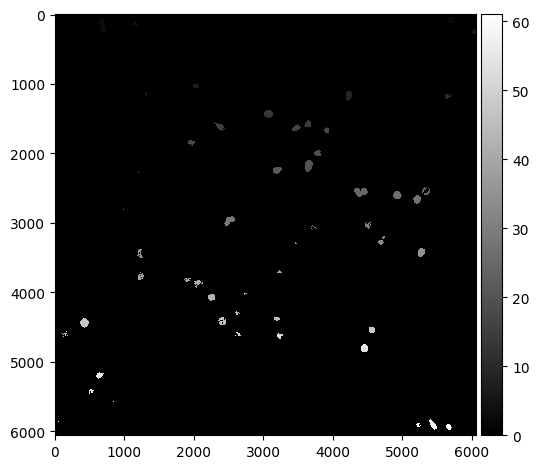

[313. 168.]


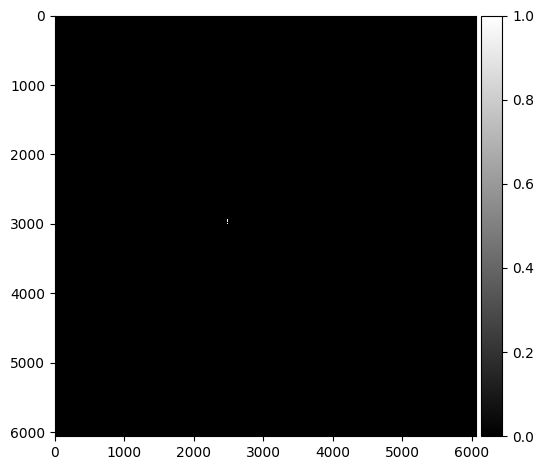

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_OA_FIN02_02.czi
Green Channel


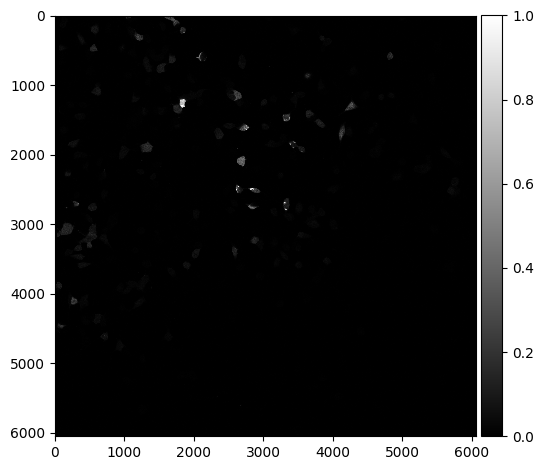

Number of cells:  66
Segmented Cells


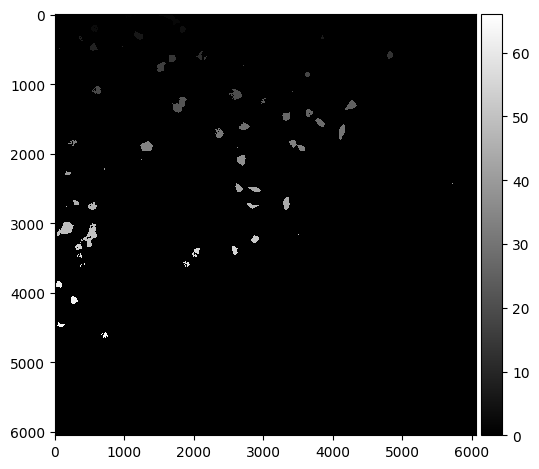

[44.]
[12.]
[ 91. 104. 127.  27.]
[590. 119.]
[295. 194.]


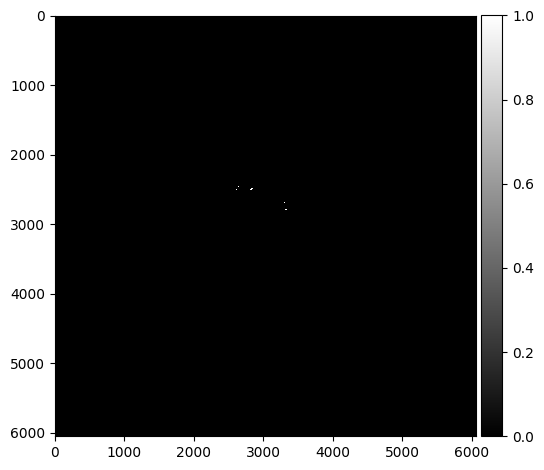

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_OA_FIN56_01.czi
Green Channel


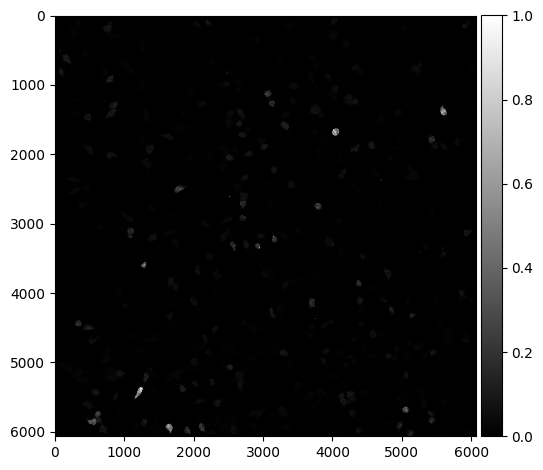

Number of cells:  124
Segmented Cells


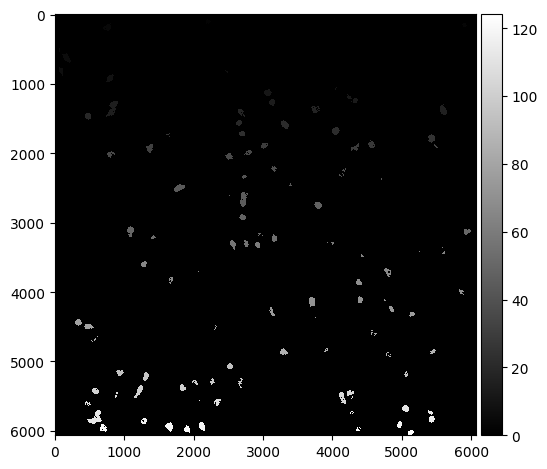

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_OA_FIN56_02.czi
Green Channel


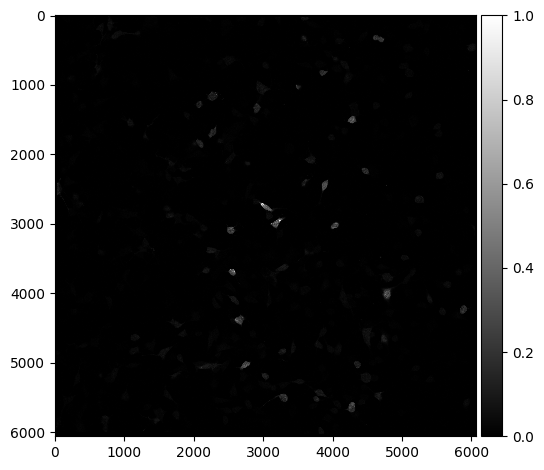

Number of cells:  103
Segmented Cells


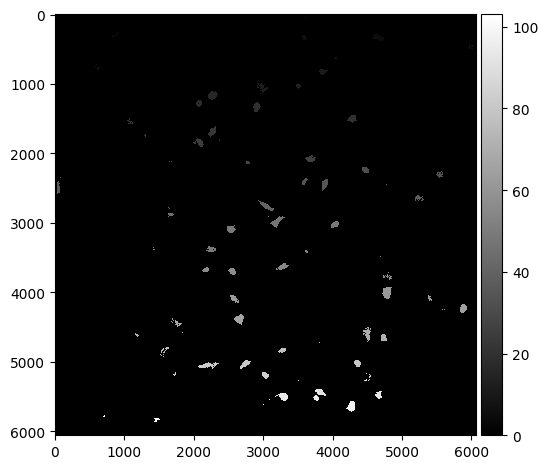

[363.]


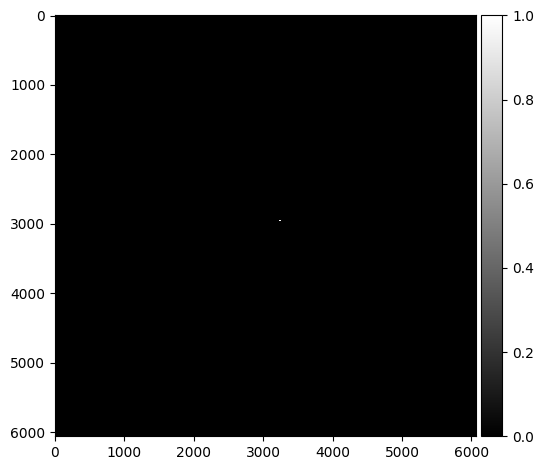

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_OA_IKE_01.czi
Green Channel


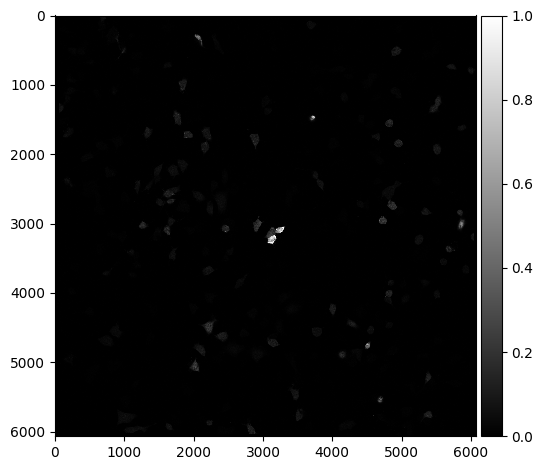

Number of cells:  108
Segmented Cells


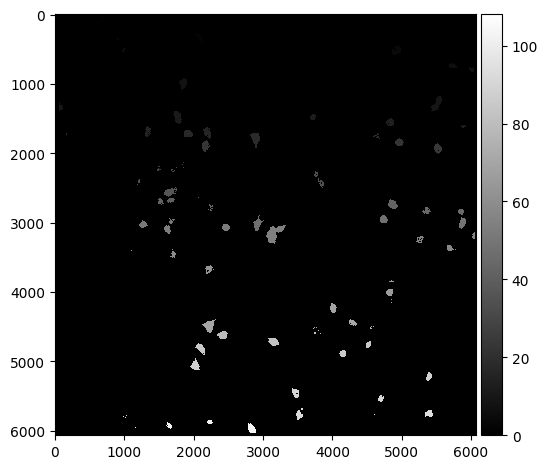

[419.  45.  39. 271. 157.  40.  58.  12.  13.]


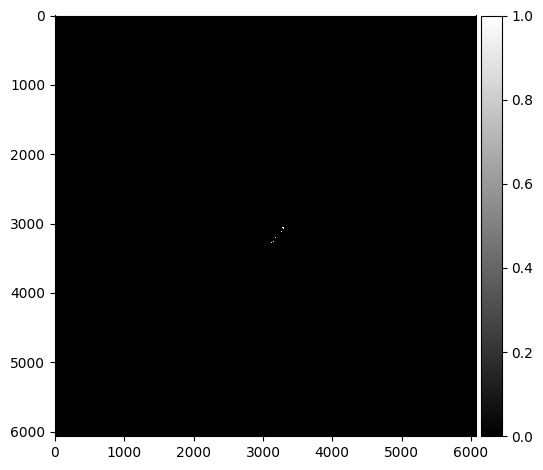

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_OA_IKE_02.czi
Green Channel


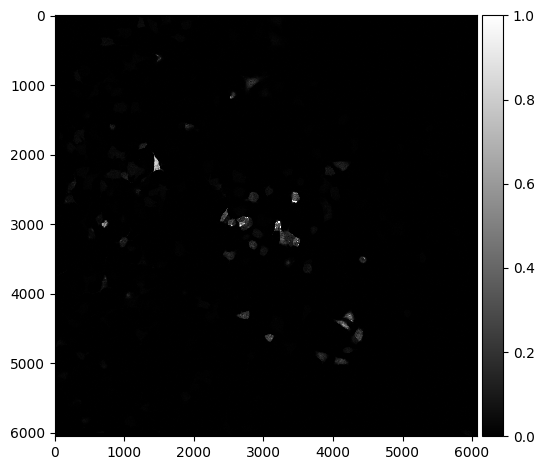

Number of cells:  50
Segmented Cells


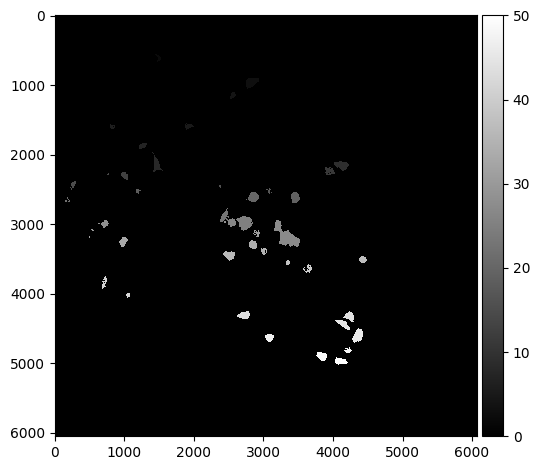

[ 161.  133. 1473.]
[123. 115.  16. 332.  16. 298.]
[135.]
[953. 224.  11.  24. 390. 351.  19.  50.  15.  17.  13.]
[13.]


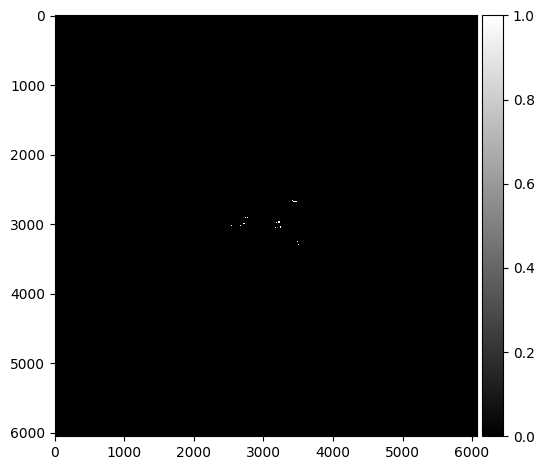

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_OA_ML210_01.czi
Green Channel


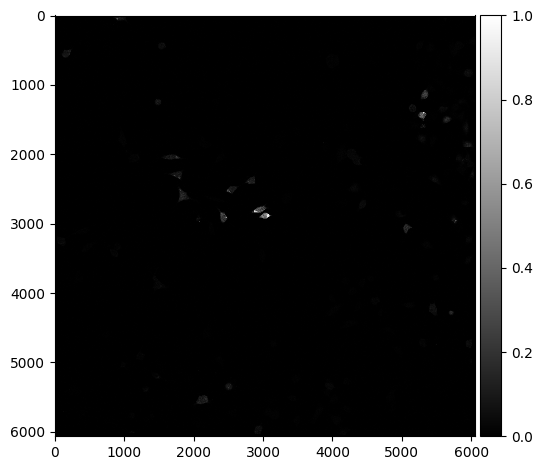

Number of cells:  40
Segmented Cells


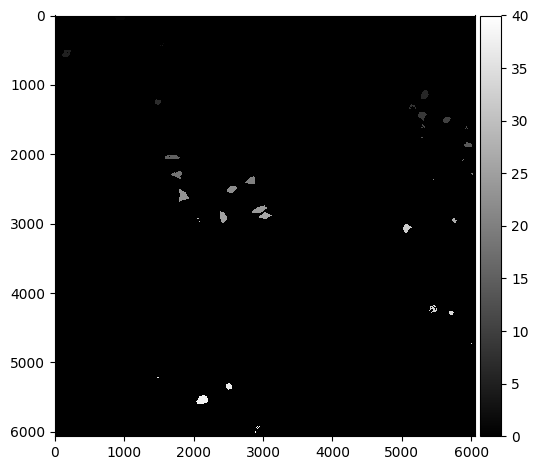

[692.]
[12.]


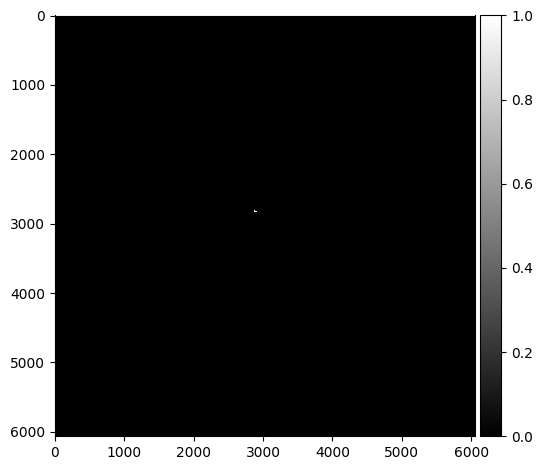

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_OA_ML210_02.czi
Green Channel


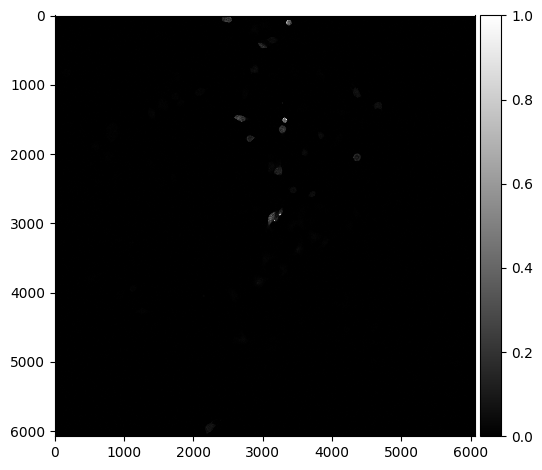

Number of cells:  17
Segmented Cells


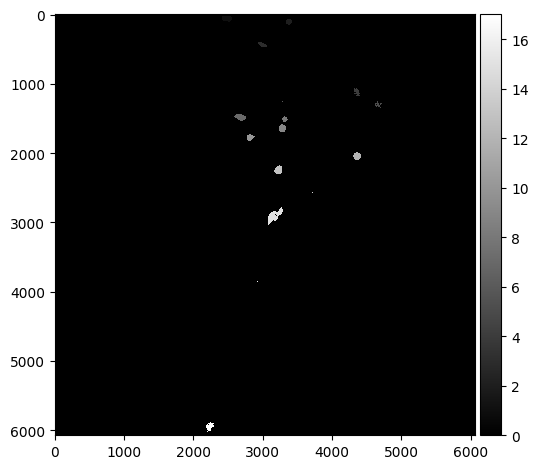

[145. 121.]


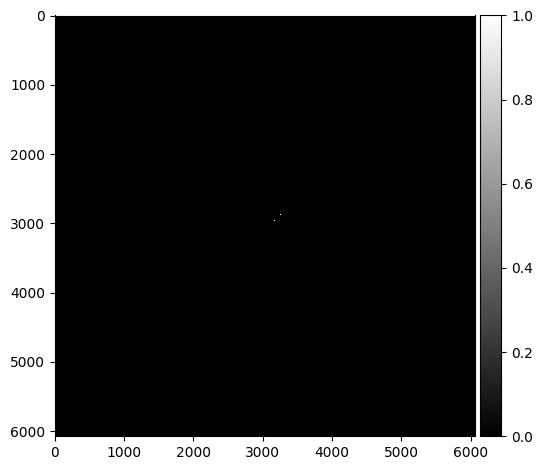

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_OA_nocomp_01.czi
Green Channel


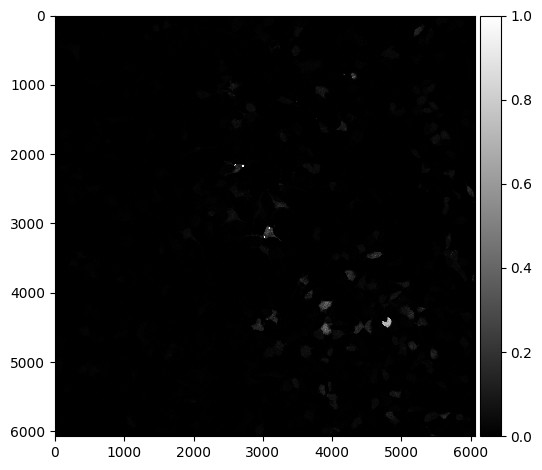

Number of cells:  102
Segmented Cells


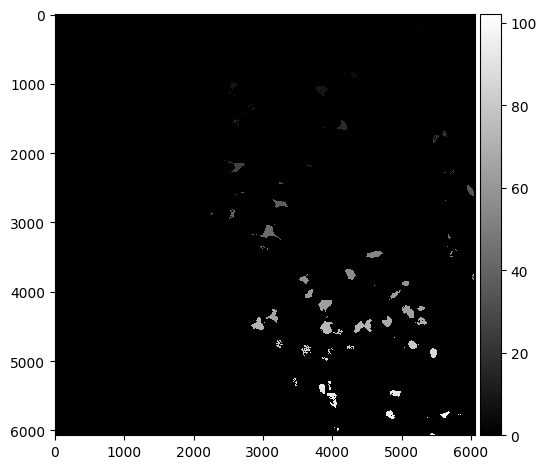

[390. 775.]
[522. 319.]


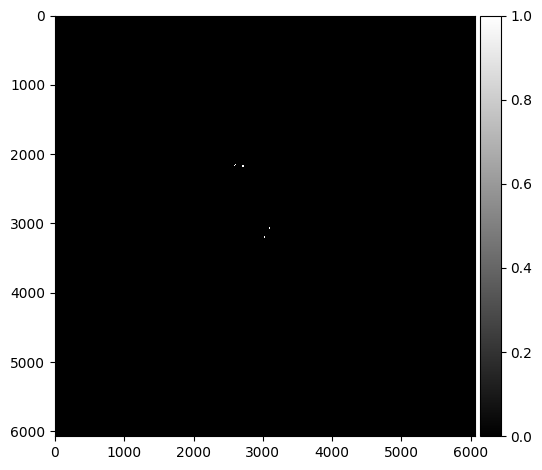

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_OA_nocomp_02.czi
Green Channel


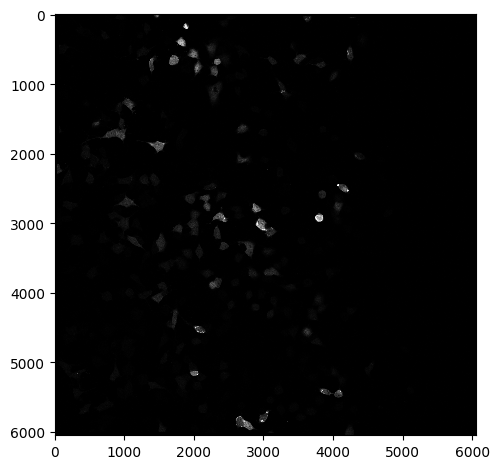

Number of cells:  102
Segmented Cells


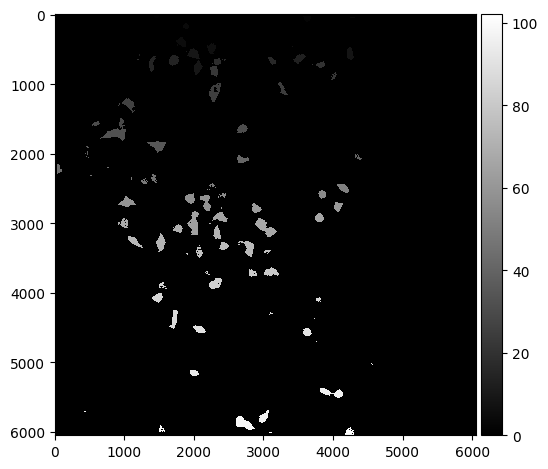

[14.]
[511. 509.]
[19.]
[17.]
[50.]
[388.  79.]
[11. 35. 77. 87. 13.]
[294.  95.  80.]
[161.]
[ 98.  47. 126.  43. 155.]
[ 64.  20.  27. 376.  16.]


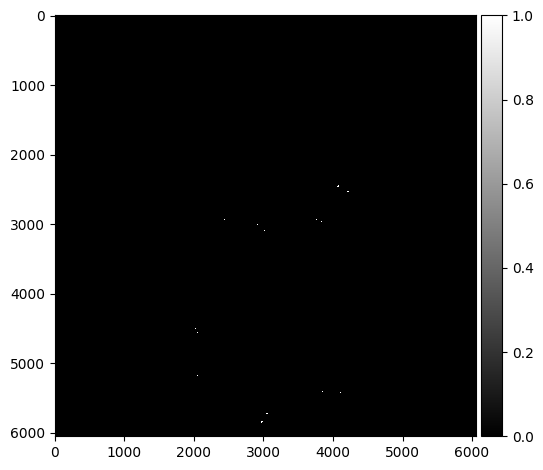

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3K_OA_erastin_01.czi
Green Channel


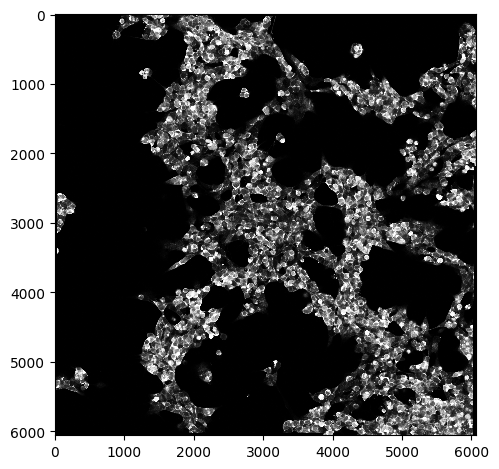

Number of cells:  80
Segmented Cells


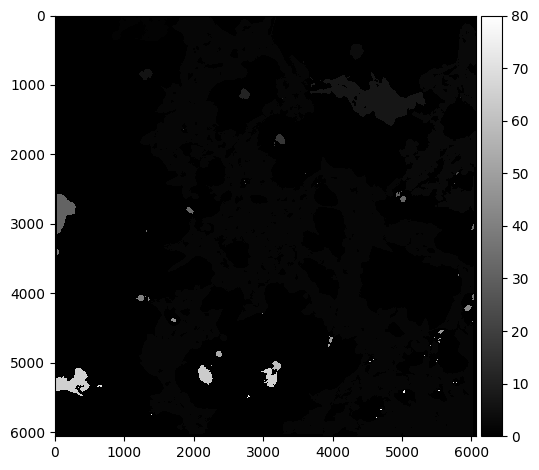

[ 630.   13.   87.  866.   15.  282.   71.  169.  494. 1040.   29.   25.
  279.]
[  11.  450.   12.  782.   43.  145.   17.   22. 1091.   93.   13.  622.
   38.   17.  264.  868.  134.   75.   11.   18.   52.   16.  159.   26.
   62.  114.  462.   96. 1153.  235.  131.  220.  440.   41.   28.   47.
   20.  466.  751.  522.   33.  810.  873.   79.  169.   12.   18.   11.
   51.  453. 1157.  210.  136.  863.  289.   11. 1259.  127.  713.  602.
   43.  201.   22.  149.  290.  281.  607.   61. 1018.  763.  729.   45.
   49.   71.  222.  849.   28.  173.   23.  928.  142.  115.  342.  399.
  412.   18.  316.  110.  594.   16.  132.   17.   16.   20.   26.  693.
   72.   39.  289.  297.  657.  398.  526.  406.   44.   14.   36.   90.
  598. 1140.   40.   37.   96.  775.  235.  728.   13.  414.  129.   97.
   14.   13.  337.   14.  484.   28.   15.  485.   14.  272.  192.   20.
  246.   13.   87.   97.  301.  399.  295.  247.   43.   68.  242.   20.
   31.   59.  112.  650.  416.   26.   44. 

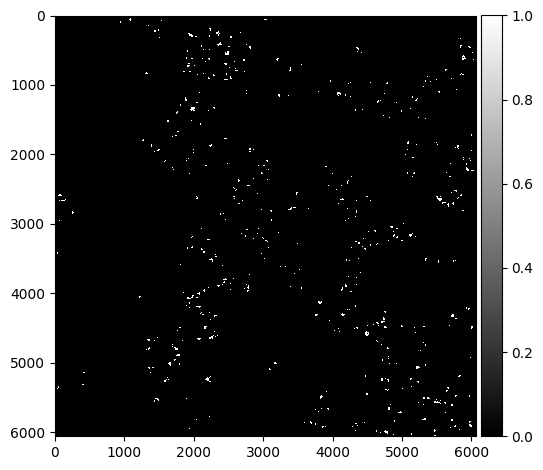

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3K_OA_erastin_02.czi
Green Channel


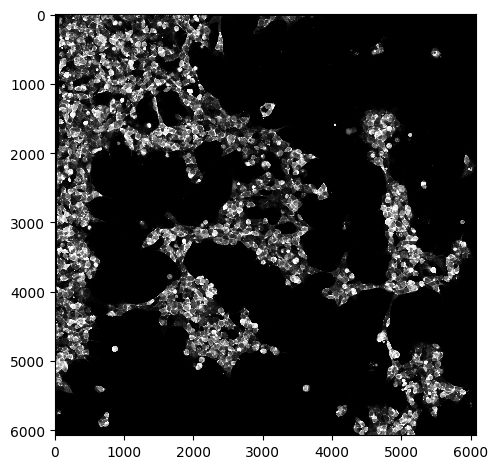

Number of cells:  114
Segmented Cells


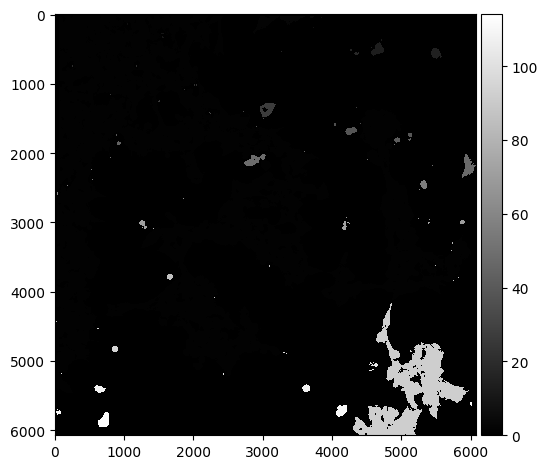

[  86.  655.   71.  776.  538.  298.  645. 1249.   76.  147.  320.   20.
  571.   47.   71.   12.  272.   39.  310.  107.  693.   23.  102.  193.
  730.   25.   42.  653.  754.  135.  117.   35.   11.   41.   61.   28.
  147.  162.  117.   52.  679.   41.  279.  762.   15.   31.  977.   45.
   96.  184.  138.   34.   20.   36.  731.   81.   18.  736.  134.   31.
   16.   76.   13.   32.   82.   42.   94.   58.   99.   46.  418.   18.
   26.   24.   12.  599.   41.  345.  187.  898.  233.  683.   11.   15.
   21.   11.   31. 1391.  149.  836.  643.   34.   15.   60.   13.   44.
   15.   20.   44.  190.   19.  187.  599.  101.  119.  236.  435.   29.
  195.   21.   32.   23.   41. 1133.   75.   34.   19.   24.  118.   19.
  233.   24.  291.   27.  547.   70.  591.  154.   47.  130.  204.   15.
 1395.   34.   13.   44.   34.   92.   16.  511.  332.  265.  559.  950.
  860.   12.   68.   62.   39.   14.   27.  127.  966.  129.  177. 1488.
   13.   42.   20.   98.  705.   23.  160.   87.  6

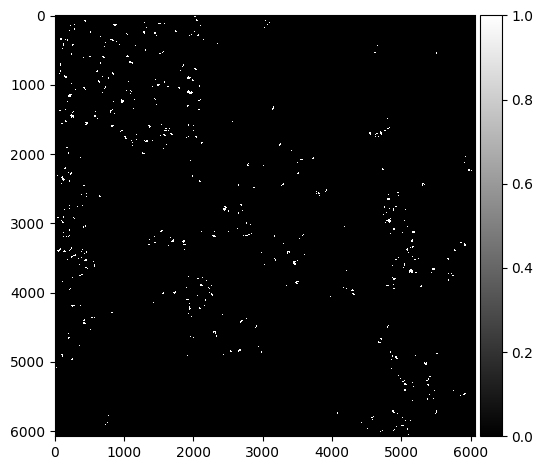

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3K_OA_FIN02_01.czi
Green Channel


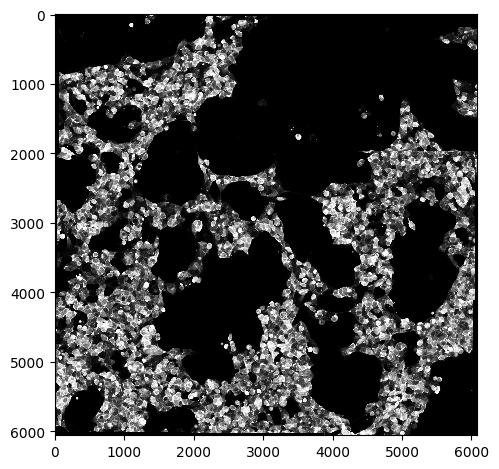

Number of cells:  106
Segmented Cells


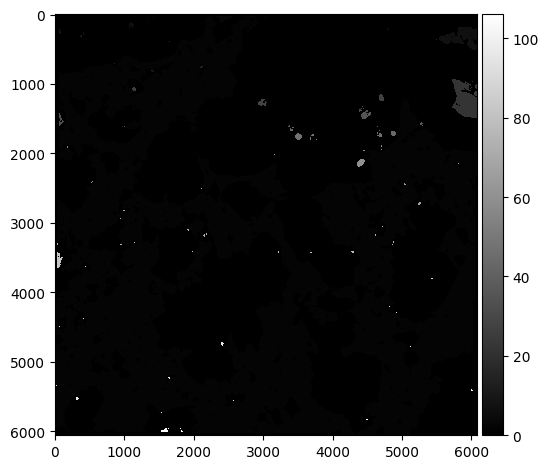

[93. 83.]
[115. 180. 260. ... 223. 181.  27.]
[107.]
[ 109.   36.  852.   51.   37.   21.  117.   66.  291.   55.   12.   12.
   69. 1056.   17.  687.  312.]
[225.  31. 369.  12.  31.  35. 332.  52. 772.]
[ 40. 175.]
[32.]
[14.]
[31.]
[92.]


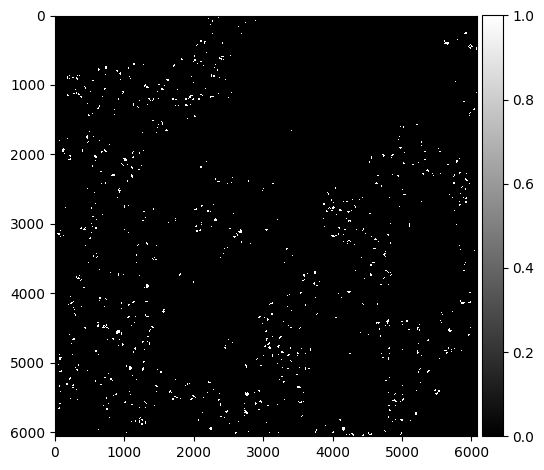

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3K_OA_FIN02_02.czi
Green Channel


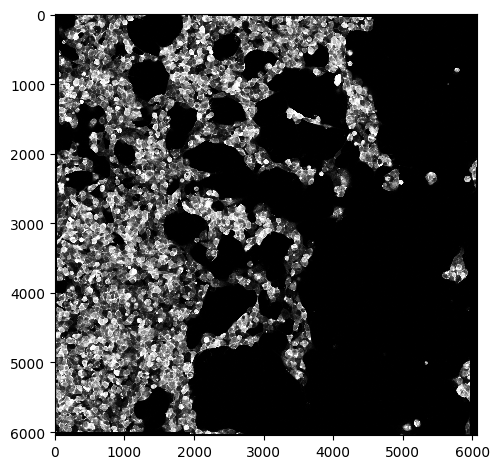

Number of cells:  73
Segmented Cells


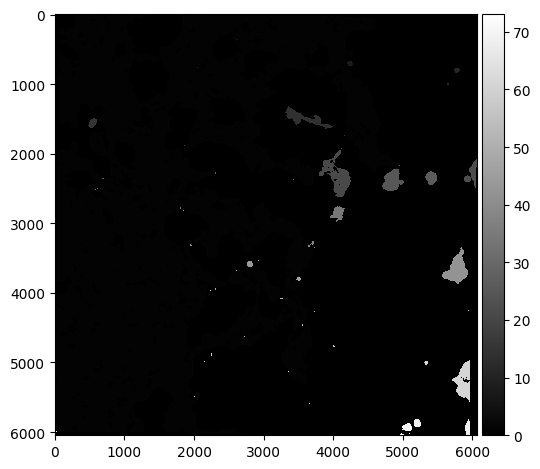

[ 95.  38. 322. ...  43. 254.  34.]
[259.]
[ 39.  16.  83. 541.  84. 107. 145. 114.  71.]
[ 53.  67. 319.  34.]
[202.]
[  49.  201. 1117.]
[482.]
[61. 31.]
[347.  34. 305.  17.  47.  28. 368. 174. 554.  51. 172.  36.  12.]
[380.]
[715. 133. 524. 692. 151.  19.  16. 676.  54.]
[ 50. 718. 209.]
[69. 34. 15. 13.]


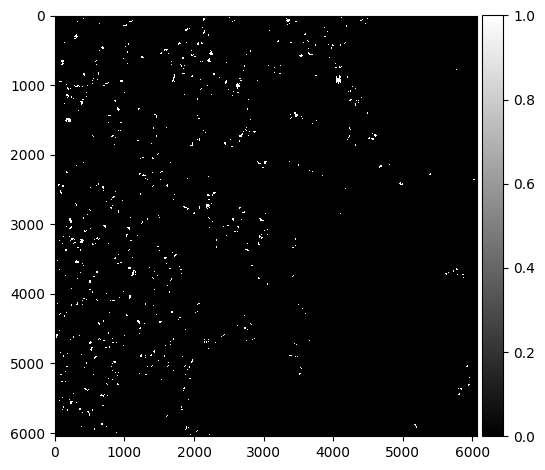

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3K_OA_FIN56_01.czi
Green Channel


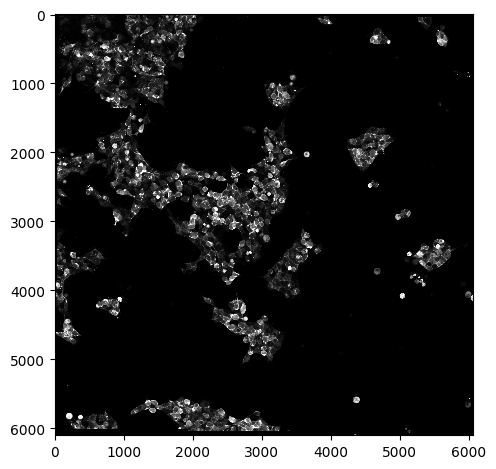

Number of cells:  143
Segmented Cells


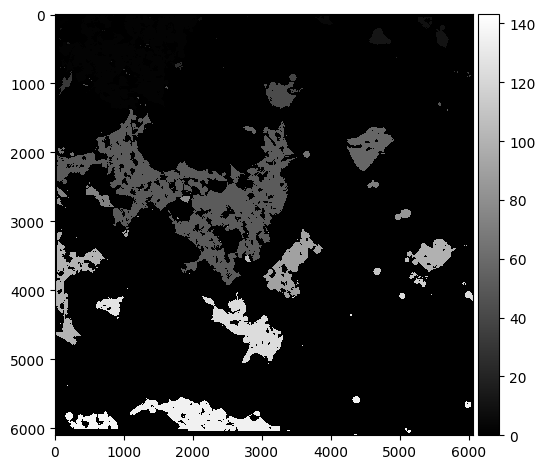

[  41.   57.   19.   99.   40.   13.   16.   11.   24.  510.  193.  159.
   17.   52.   46.   13.   27.   31.   23.  255.   17.   17.   68.   41.
   11.   14.   71.   23.  232.  689.   15.  346.  222.   12.   20.  403.
   41.   96.   25.   21.   11.  157.   43.   17.   63.   30.   43.  108.
   95.  210.   11.   75.  341.   15.   13.   23. 1243.   55.   84.   24.
  647.   44.   43.   21.   74.   15.  173.   12.  241.   73. 1166.   13.
   27.   97.  321.  122.   21.   17.   16.   35.   17.   12.   21.  298.
  340.  126.   15.  137.  272.   19.  396.  116.   15.  137.   21.   36.
   26. 1394.   13.   16.   13.   45.   25.   14.   26.   15.   30.  110.
   59.   61.   35.   12.   24.   12.   11.   70.   33.   14.   42.   79.
   26.  385.  149.   26.  591.   50.   51.  129.   19.  245. 1451.  120.
   15.  295.  262.  146.  160.  118.   20.   50.   82.   23.   46.   24.
  511.   69.   38.  246.  157.  456.  128.   88.   59.   14.  957.  165.
   53.   32.   38.  367.   39.   49.   56.   14.   

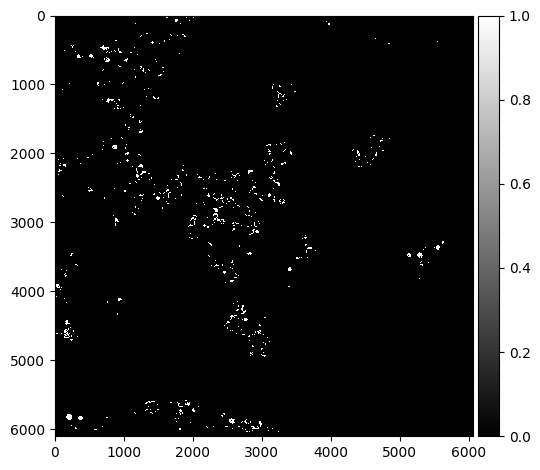

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3K_OA_FIN56_02.czi
Green Channel


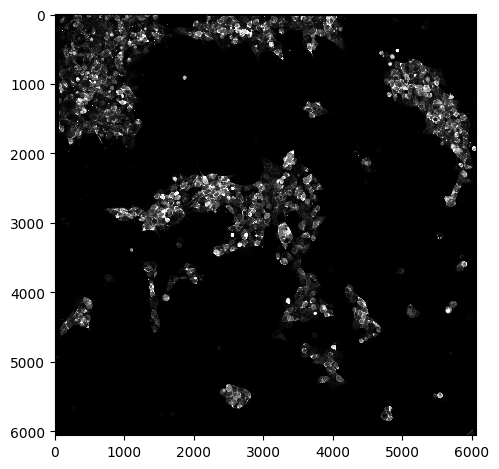

Number of cells:  159
Segmented Cells


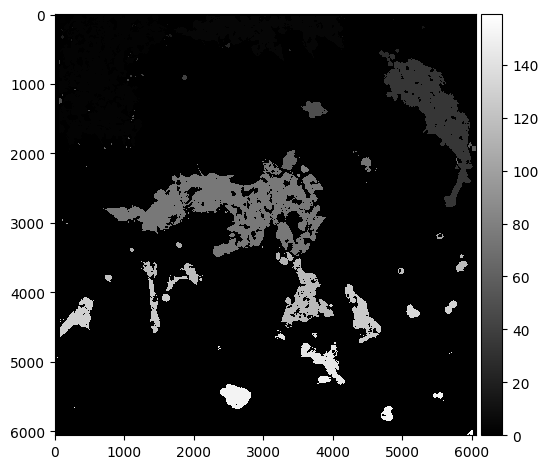

[  49.   26.   19.   21.   29.   22.  137.  251.   14.   14.   51.   22.
   11.   29.   47.   12.   15.   27.   12.  266.   37.   44.  144.  261.
  569.   44.  597.  160.  267.  113.   34.   32.   33.   17.  401.   71.
  217.   33.   16.  214.  114.   30. 1194.   14.   37.   62.  117.   82.
   74.   97.  274.   44.  197.   29.  274.   62. 1191.   16.  566.   51.
  153.  862.   58.   70.   19. 1460.   12.   89.   20.   48.   12.   23.
   38.   81.   49.   12.  278.  107.   74.   27.  891. 1272.  284.   41.
  197.   15.   32.   59.   56.   62.   27.   24.  126.   30.   75.   55.
   17.   24.   43.  378.   12.   26.   15.   21.   21.   12.  188.  450.
   57.   58.   25.   92.   23.   12.  151.   33.   23.   42.   37.   15.
   49.  589.   11.   19.   44.   14.   72.  377.  836.   28.   12.   33.
   23.   53.  101.   20.  714.   21.   36. 1133.   32.   15.  167.  120.
   29.   25.   17.   27.   21.   26.   13.   13.   18.  526.   18.   28.
   14.   81.  329.  111.   28.   27.   11.  908.  4

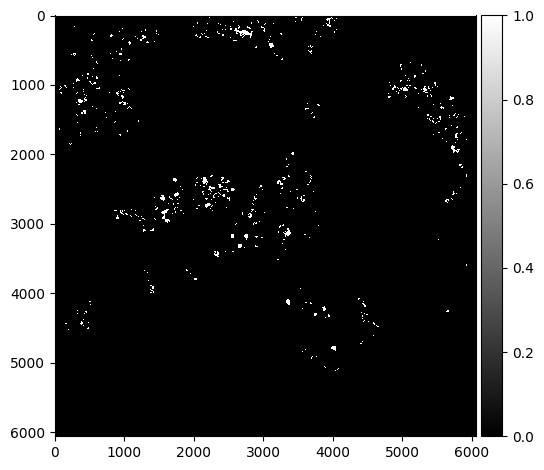

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3K_OA_IKE_01.czi
Green Channel


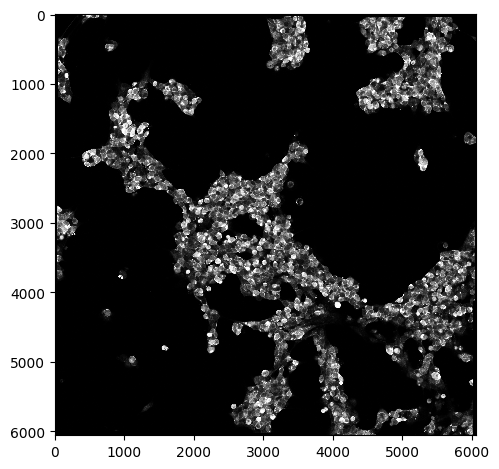

Number of cells:  107
Segmented Cells


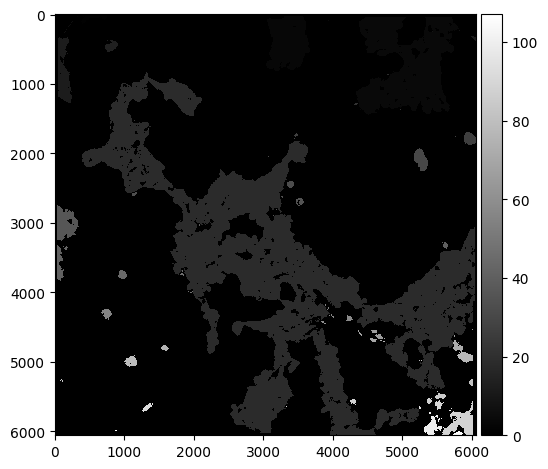

[1101.   14.]
[ 14.  55. 160. 147.  11.  50.  28. 728.  17. 879.  42.  51.  50.  11.
  40. 211.  11. 127.  48.  24. 168.]
[  13.  229.  235.   55. 1020.  401.  712.   21.   17.  271.  311.   16.
   27.  184.  232.   55.   26.  870.  155.   39.   93.  132.  552.  150.
   88. 1357.   20.   17.   14.   67.   30.  253.   18.   20.  105.   14.
  324.   29.   40.  455.  104.   33.  779.   19.   57.   14.   22.   29.
  895.   21.   24.  472.  405.   46.  657.   17.   13.   11.  112.]
[ 108.  275.   46.   49.   73.  400.  323.   21.   21.  147.   83.   49.
   33.  733.   32.   29.  246.  485.   56.  186.   21.   15.   21.  568.
  309. 1447.   70.  179.   17.   24.   18.   17.]
[ 183.   53.  109.  360.  488.   42.   52.  153.  269.   14.  111.   17.
  183.  146.   13.   37.   42.   98.   12.   25.   15.  203.  116.  488.
   42.  554.   35.   15.   77.   32.  688.  259.   19.  133.   12.   44.
  209.  843.   13.  546.  740.   23.   23.   26.  103.   71.   15.   15.
  769.  150.   19.  488.   13.

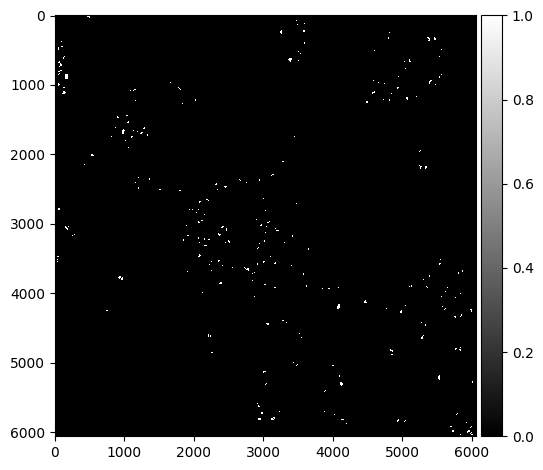

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3K_OA_IKE_02.czi
Green Channel


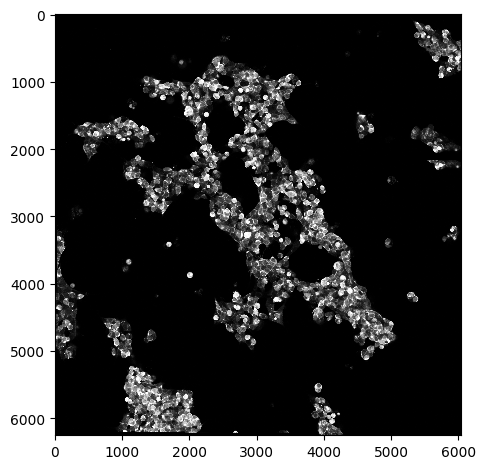

Number of cells:  116
Segmented Cells


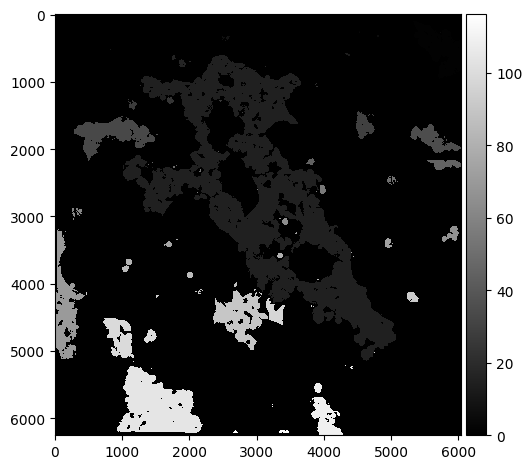

[ 540.   93.  406.   49.   12.   63.   23.   79.   16.   20.   12.   82.
   14.   22.   11.   15.   12.  144.   34.   25.   42.  539.  532.   16.
 1095.]
[  31.   21.  300.   43.   20.  121.   80.  180.   23.  635.  390.  508.
  136.  104.   26.  984.  126.   21.   19.  112.  137.   55.   41.   17.
  265.  755.   32.   30.   30.  269.   44.  745.  428.   14.   54.   17.
   76. 1005.  340.   18. 1356.   36.   33.   33.   16.  110.   18.   50.
   12.   81.  470.  646.   14.  316.   21.   77.   40.   12.   89.   59.
   75. 1206.   70.  928.  880.  172.  195.   17.   51.   18.  189.   91.
  490.   15.  487.   67.  111.   84.   90.  215.  651.  712.   15.   23.
  219.   47.   51.  238.  420.  540.   63.  492.   12.   30.  906.   41.
   49.   59.  116.  915.  161.   16.  351.   98.  168.   33.   20.   12.
  453.  853.   12.   24.   51.  260.   36.  438.   42.   41.  830.  590.
  284.   55. 1113.   43.  182.  214.  524.   20.  240.  249.  330.  594.
   11.  339.   21. 1076.   22.   49.   11. 

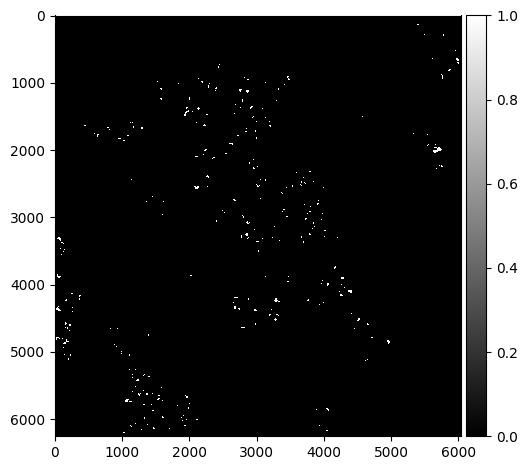

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3K_OA_ML210_01.czi
Green Channel


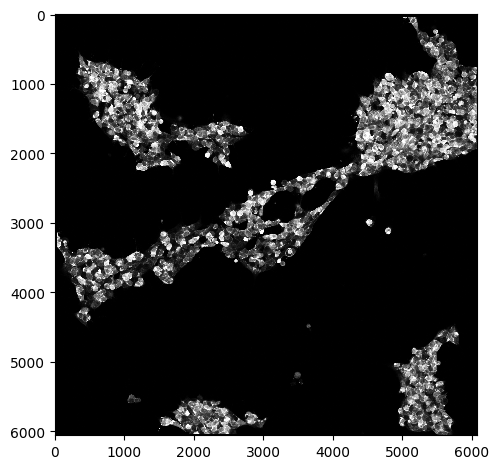

Number of cells:  60
Segmented Cells


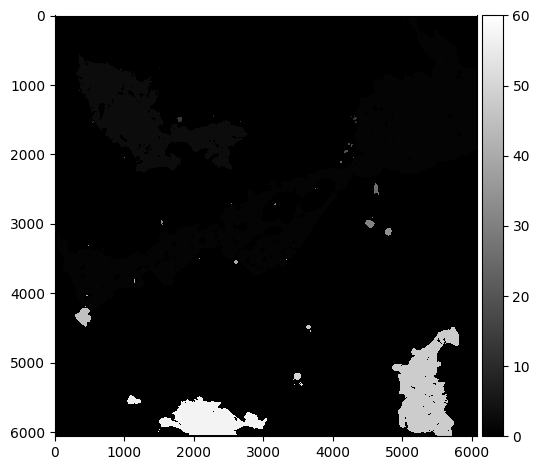

[ 152.   79.  218.   40.   97.   28.  189.  321. 1061.   31.   16.   82.
   99.  335.  192.  278.   57.  724. 1125. 1087.   36.   20.   29.  354.
  451.   68.   39.   68.  427.  468.  367.  135.  149.   18.   18.  220.
   48.  754.   96.  229.   53.   14.  311.   13.   52.   52.  449.   36.
  405.  115.  359.  397.  346.  100.  158. 1337.  266.   31.  188.   51.
  649.  707. 1029.   79.   13.   71.   26.   13.  341.   49.   34.   16.
   42.  171.   31.   55.  454.  346.   61.   37.   34.   78.  910.  644.
   32.   73.   61.   31.  624.   21.   13.   13.   25.   21.  119.   15.
   61.  275.  198.   13.  235.   66.  292.   25.  159.   56.  114.   40.
  129.  137.  939.  944.   21.  235.   85.   75.   44.   30.   32.   23.
   17.   92.   89.   62.  281.  376.   43.  776.   19.   26.   80.  181.
  260.   36.   22.   52.  352.   88.   12.  198.  610.   19.  128.   11.
   24.  717.   48.  258.  116.   90.  807.  388.  117.   20.  135.   40.
  778.   40.  109.   44.  212.   20.   17.  199.  3

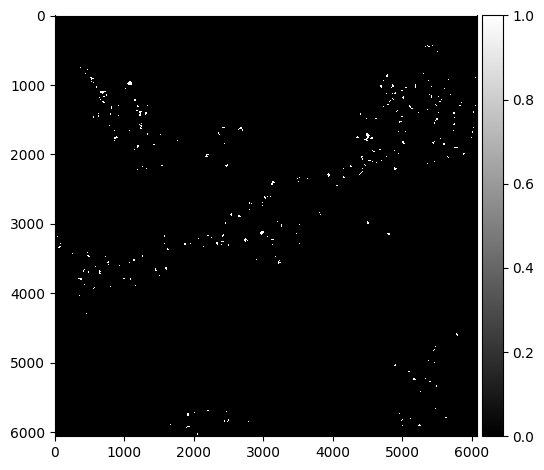

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3K_OA_ML210_02.czi
Green Channel


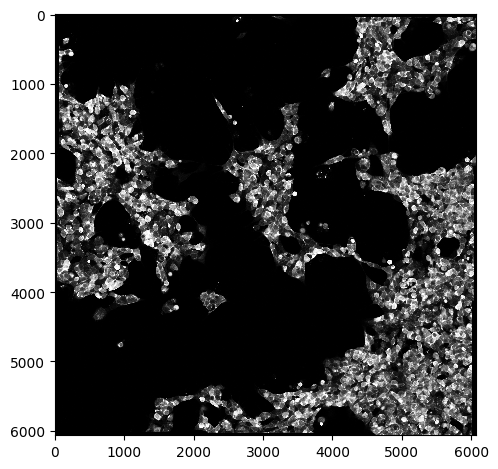

Number of cells:  105
Segmented Cells


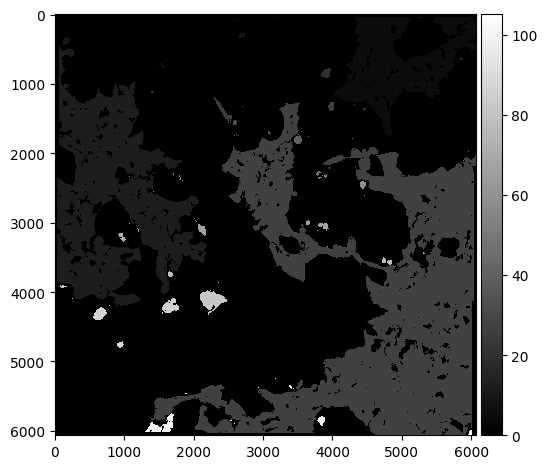

[22.]
[306.  78.  68.  21. 340. 618.  31.  49. 118. 288. 263. 116. 311.  33.
  73. 145. 216.  85. 101. 308.  76. 508. 560. 219.  27. 554. 123. 814.
 321.  39. 431.  73.  28. 184. 112. 716.  21.  33.  95. 313.  43. 499.
  29.  15.  52. 127.  11.  25.  21.  29. 388.  37.  70.  41. 106. 104.
  30.  28.  27.  23. 156.  32.]
[43.]
[  23.   18.   90.  935.   17.  315.   69.   17.   18.  178.  197.  118.
   17.  490.  184.   59.   40.  648.  581.   20.  156.   88.  566. 1088.
  737.   11.  324.  217.   31.   18.  100.  601.  845.  225.   44.   78.
  538.  200.   84.   39.   18.  115.   19.   13.   51.   55.  167.   36.
   15.   84.  210.   42.   23.   54.  643.  218.  492.   27.  208.  141.
  155.  101.   48.  184.   19.  150.  198.  768.  105.   86.   36.   55.
   38.   93.   43.  377.  213.   36.   30.   11.  366.   19.   16.   75.
   14.   37.  207.   66.   96.   17.   24.   28.   88.  195.   17.  615.
  421.   17.   20. 1047.  746.  530.   26.   50.   32.  111.   14.   14.
  152.   32.   

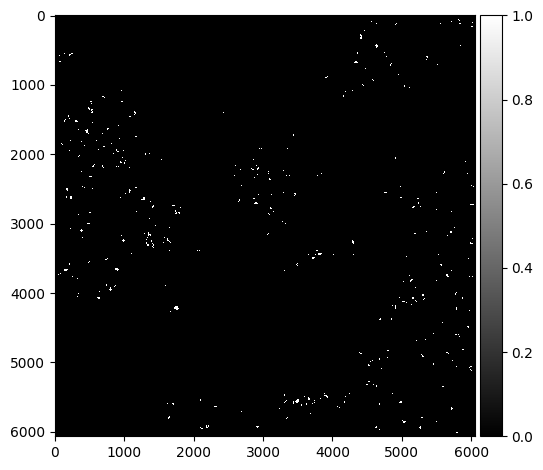

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3K_OA_nocomp_01.czi
Green Channel


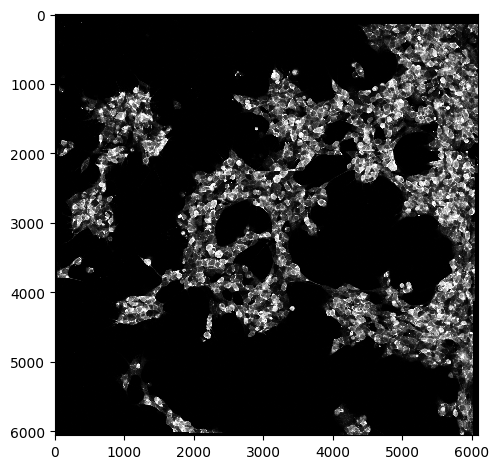

Number of cells:  93
Segmented Cells


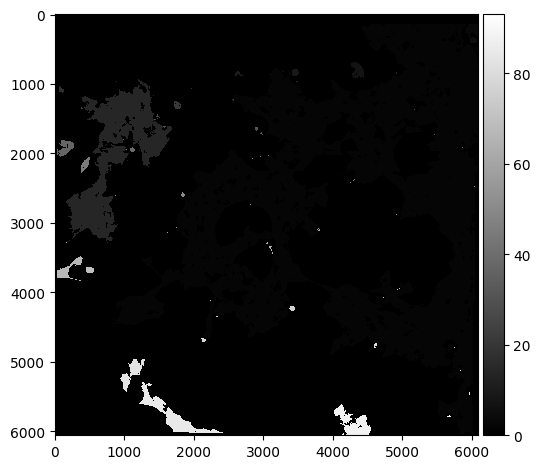

[  40.   12.  376.   23.   59.  197.  127.   20.  106.  638.   31.  154.
   50.   16.   61.   54.   13.   43.  618.   82.  473.  202.   80.   20.
  372.  864.   38.  114.   15.  228.  192.  146.   14.  171.   12.  156.
   18.   27.   18.  822.  901.  177.   13.   14.  742.  165.  107.   32.
   88.  275.  394.   13.   30.  220.   17.   26.   33.   12.   11. 1051.
   36.   85.  126.   27.  184.   40.   32.   19.  823.   21.   18.   11.
  156.   53.   11.   45.   21.   35.   36.   18.   27.  502.   68.  512.
  676.   89.   18.  174.  181.   70.  671.  242.  855. 1318.  125.   11.
  169.   42.  786.   48.   18.  369.   30.   84.   20.   30. 1162.   17.
  157.  349.  508.   15.  537.   36. 1031.   95.  117.   26.  344.   28.
   13.   22.  472.   14.   34.  503.  755.   27.   24.  310.   25.   93.
  159.  237.  123.   85.  302.  251.   38.  294.   92.   45.  204.   16.
   26.   27.   25.   15.  327.   40.   18.  514.   58.   11.  181.   13.
   20.   43.  805.   16.  322.   13.   54.  162.  1

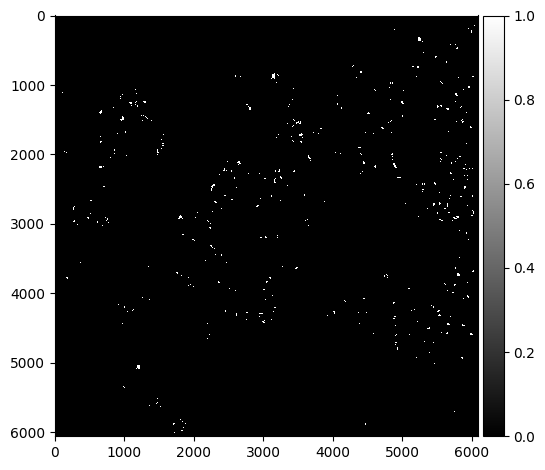

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3K_OA_nocomp_02.czi
Green Channel


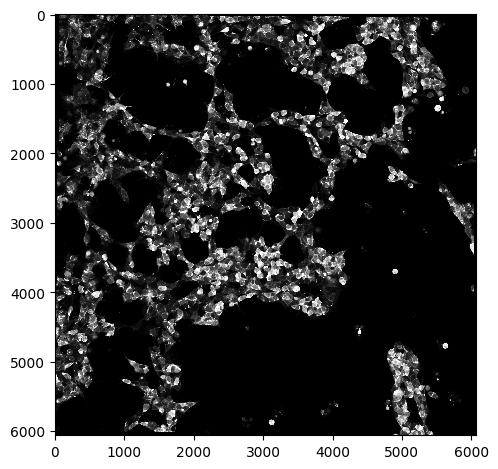

Number of cells:  226
Segmented Cells


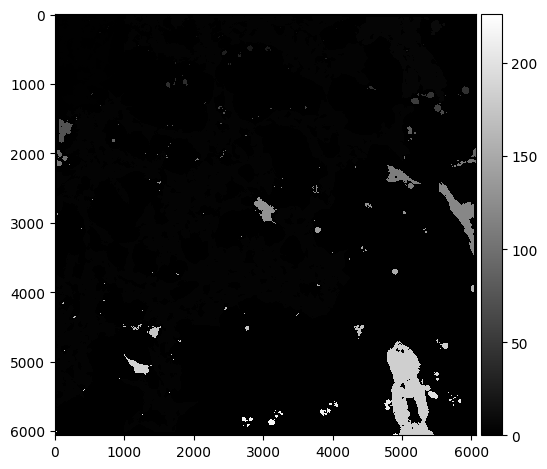

[  19.  282.   42.  650.   29.   22.   18.  313.  304.  533.   33.   13.
  484.  708.   74.   35.   92.   31.   48.  161.  106.   13.  567.  279.
  217.   15.   32.  107.  265.   14.   24.   74.  181.   86.   12.   88.
   25.   39. 1397.   24.   43.  884.   34.   11.   35.   16.  281.  122.
   19.  812.   86.  217.   16.  161.   99.   13.  120.   92.   45.   17.
  745.   17.  225.   82.   43.  171.   25.  550.   23.   32.   30.   95.]
[ 459.  358.   92.   55.   15.   75.   44.   15.   51.   49.   14.   69.
   12.   27.  999.   16.   12.  114.   48.   46.   11.  127.  753.  651.
   12.   20. 1083.  153.   18.   12.   18.  592.  447.   11.  148. 1216.
  843.   16.   25.  679.  747.  312. 1429.  256.  135.  292.   80.   56.
  159.   12.  708. 1117.   18.   29.   20.   92. 1144.  261.   40.   91.
   93.  791.  673.  289.   39.   57.  493.   11.  216.   21.  311.  155.
   12.   19.  336.  882.   56.   23.   19.  461.  137.  493. 1052.   85.
   36.   89.   25.  146.  292.   74.   12.   59.  

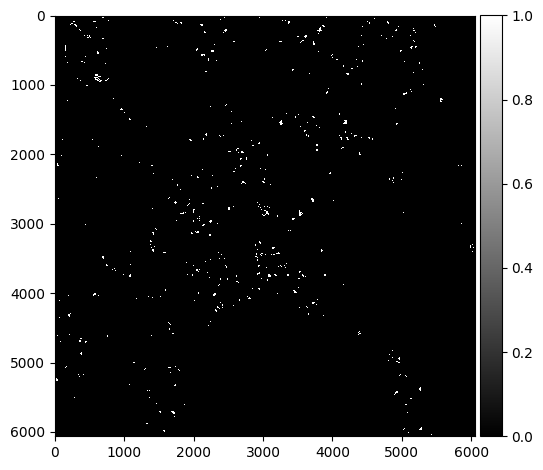

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_OA_erastin_01.czi
Green Channel


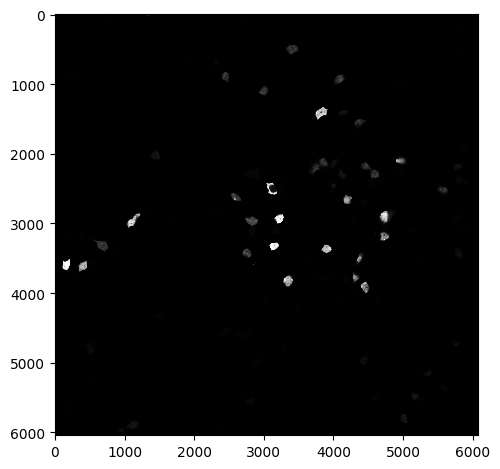

Number of cells:  48
Segmented Cells


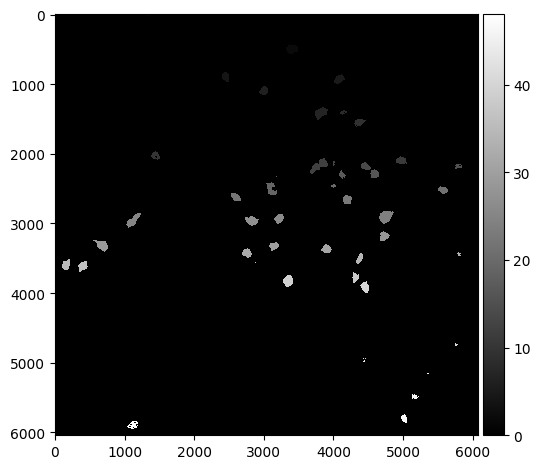

[290. 284.]
[53.]


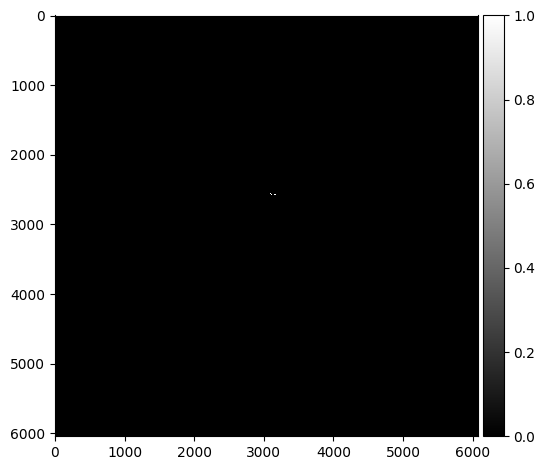

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_OA_erastin_02.czi
Green Channel


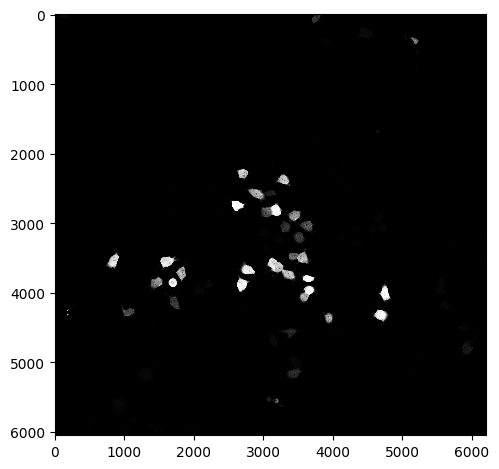

Number of cells:  50
Segmented Cells


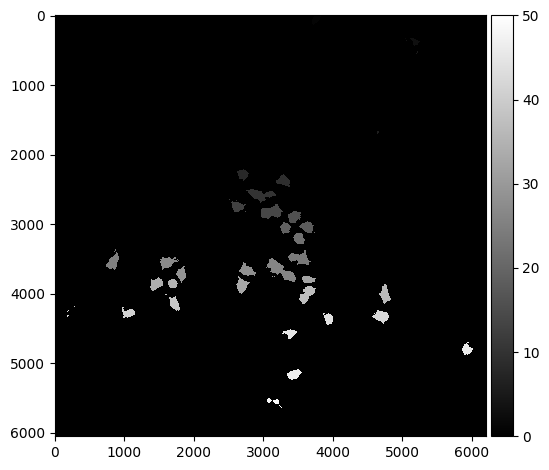

[16.]


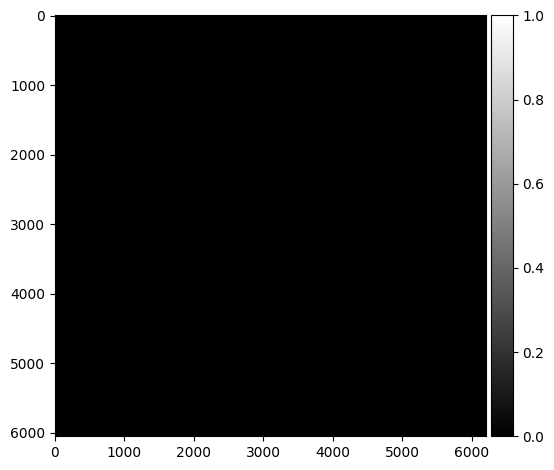

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_OA_FIN02_01.czi
Green Channel


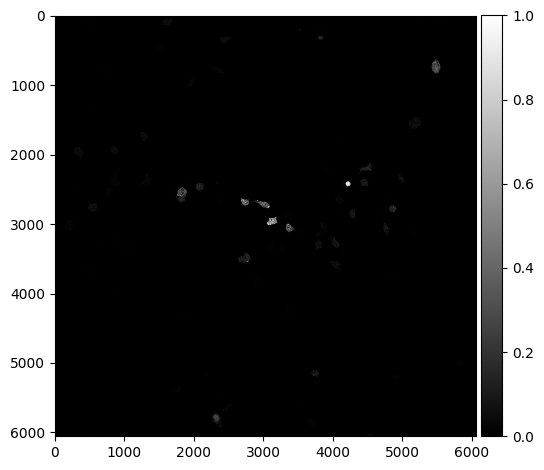

Number of cells:  40
Segmented Cells


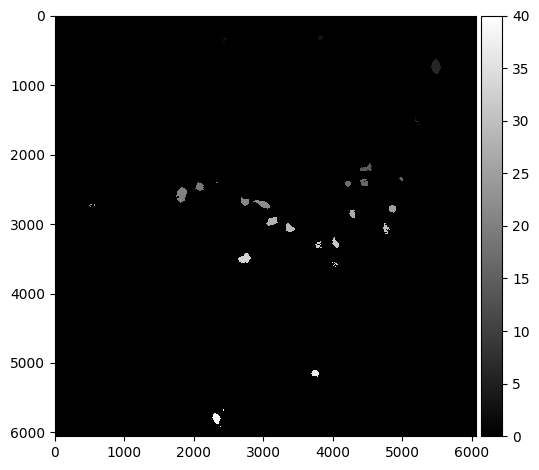

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_OA_FIN02_02.czi
Green Channel


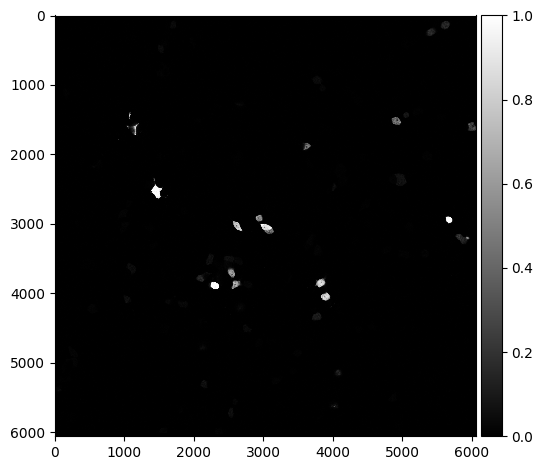

Number of cells:  40
Segmented Cells


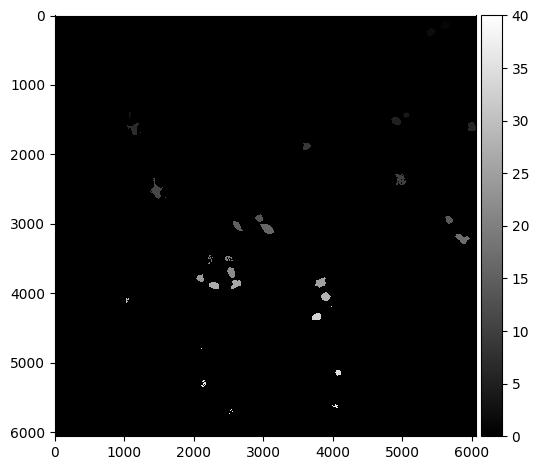

[596. 173.]


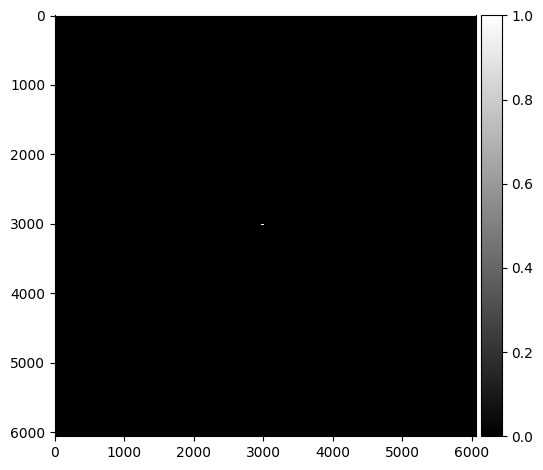

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_OA_FIN56_01.czi
Green Channel


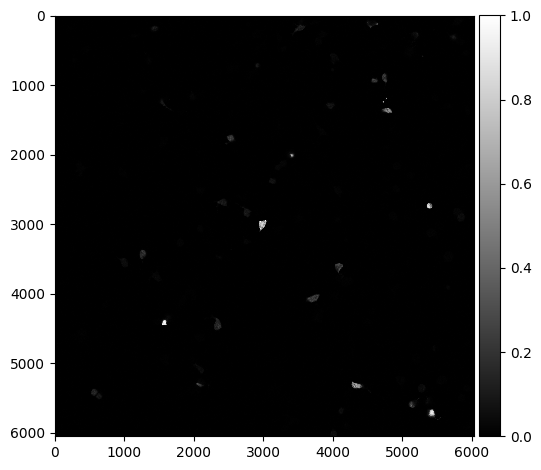

Number of cells:  49
Segmented Cells


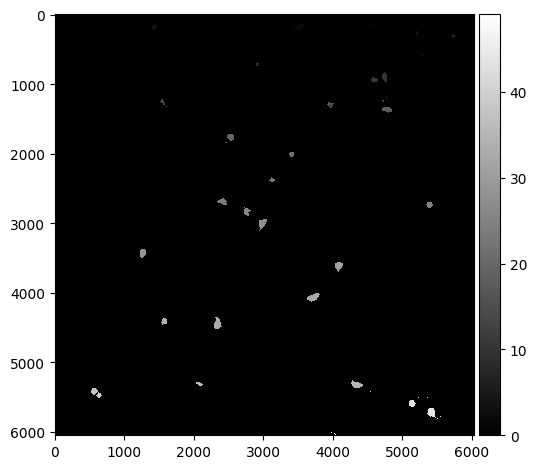

[179. 283. 201.  18.]


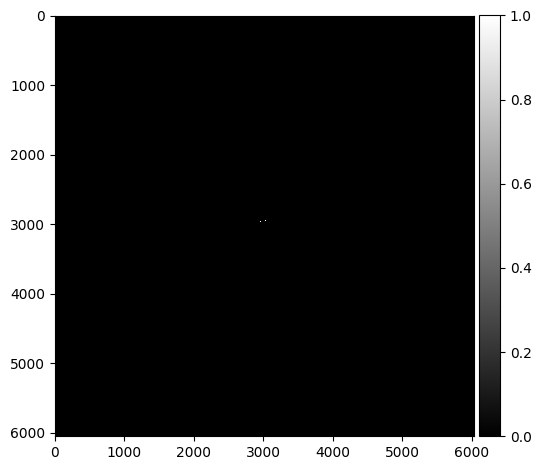

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_OA_FIN56_02.czi
Green Channel


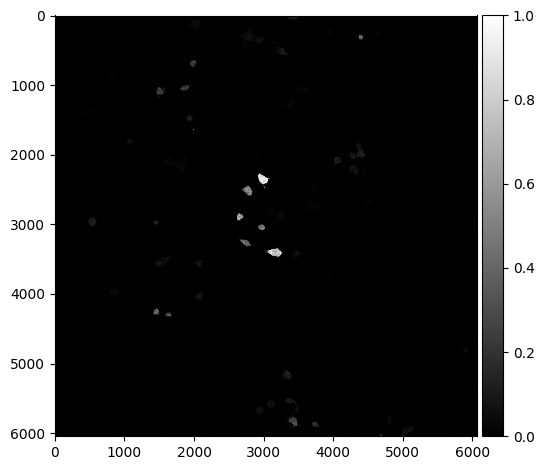

Number of cells:  47
Segmented Cells


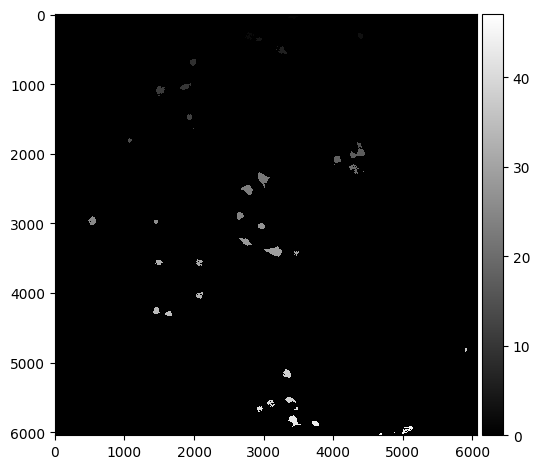

[20.]


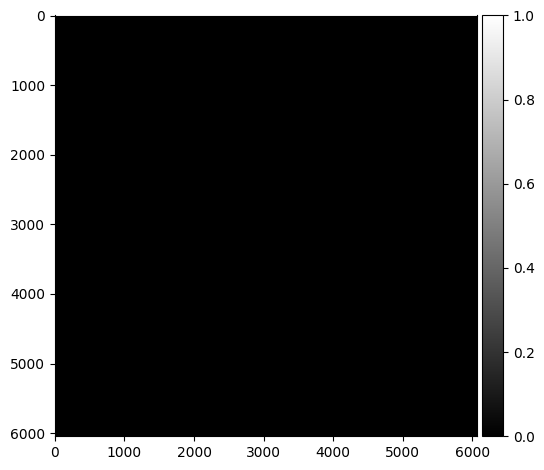

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_OA_IKE_01.czi
Green Channel


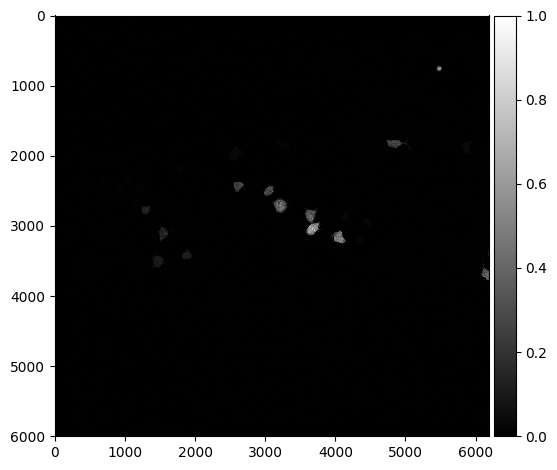

Number of cells:  19
Segmented Cells


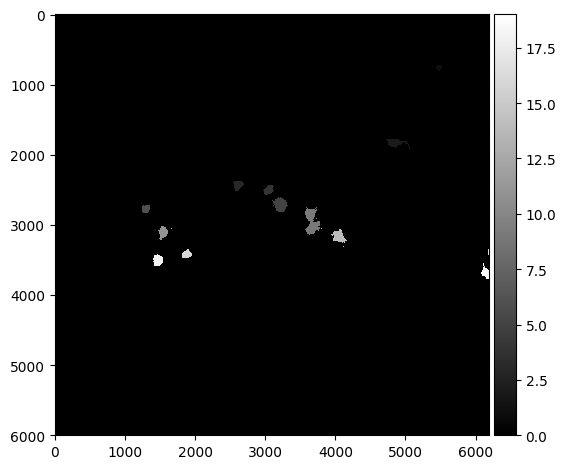

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_OA_IKE_02.czi
Green Channel


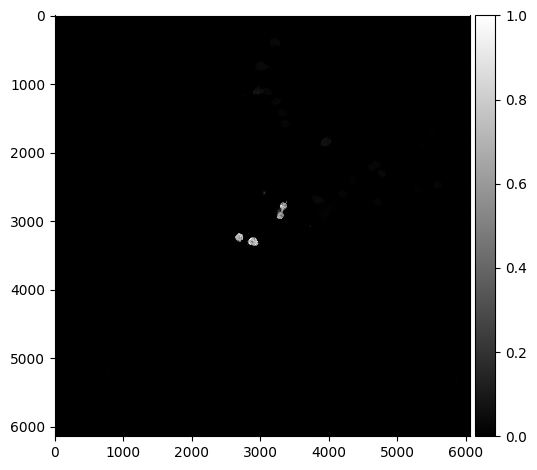

Number of cells:  8
Segmented Cells


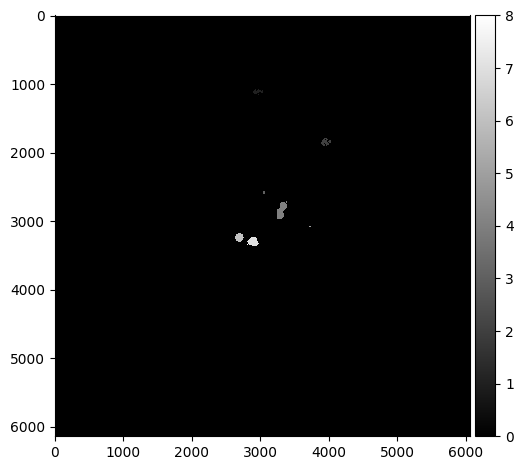

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_OA_MC210_01.czi
Green Channel


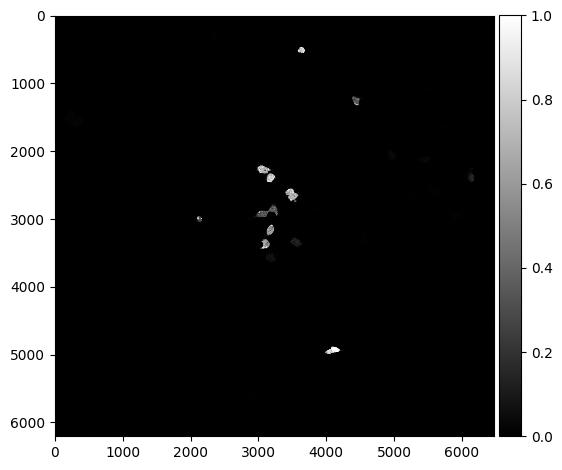

Number of cells:  14
Segmented Cells


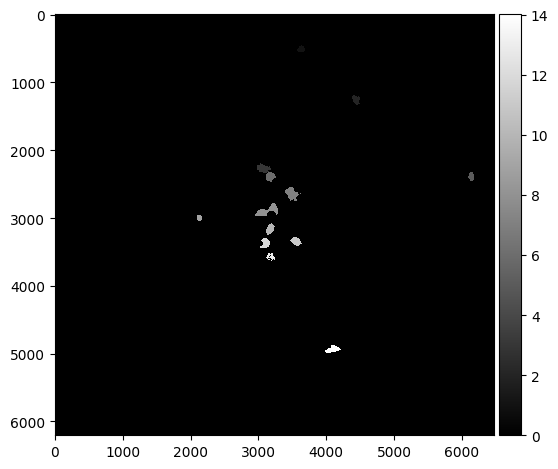

[21.]
[494.  60.]


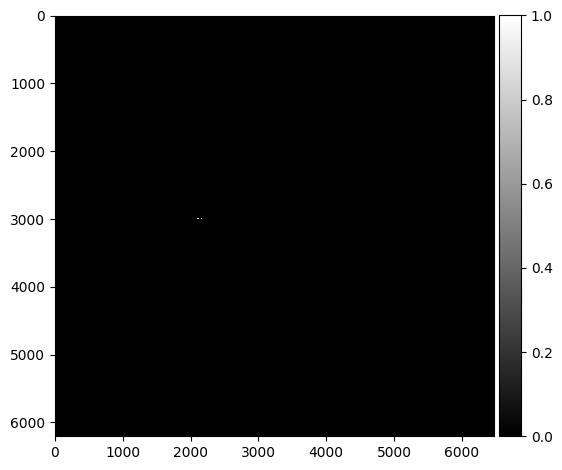

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_OA_MC210_02.czi
Green Channel


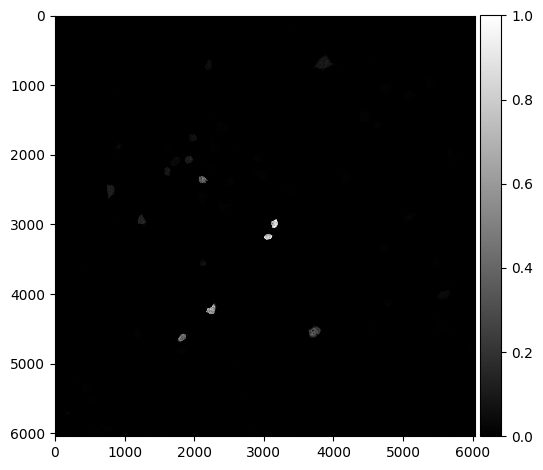

Number of cells:  17
Segmented Cells


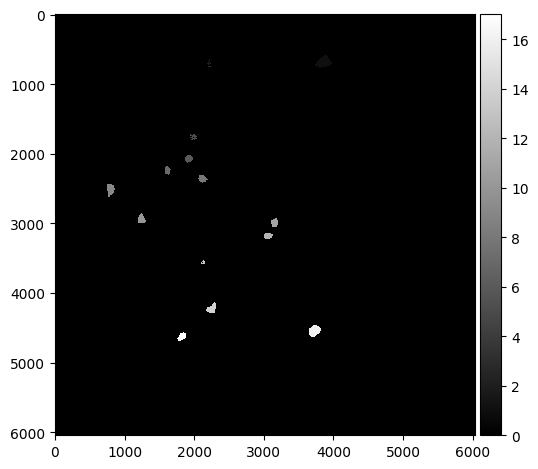

[195.  68.  82. 107.]


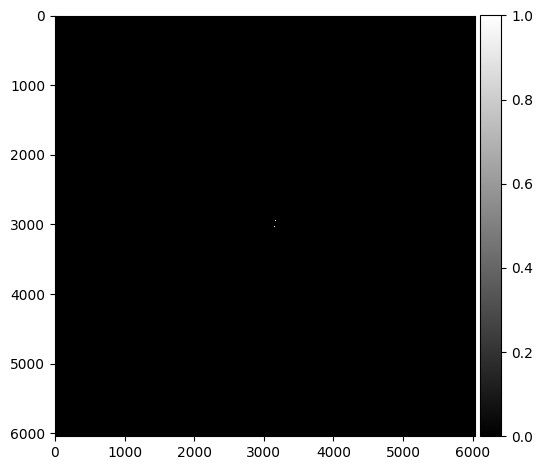

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_OA_Nocomp_01.czi
Green Channel


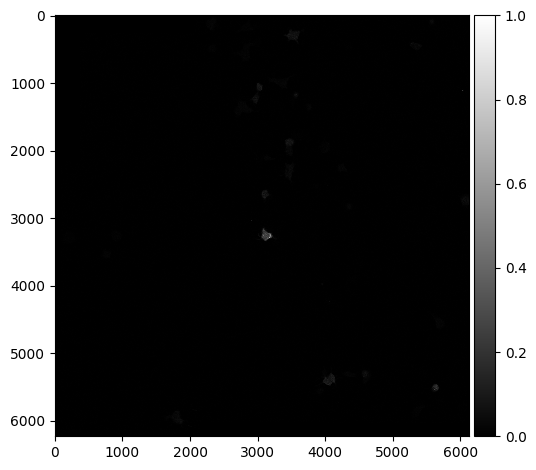

Number of cells:  14
Segmented Cells


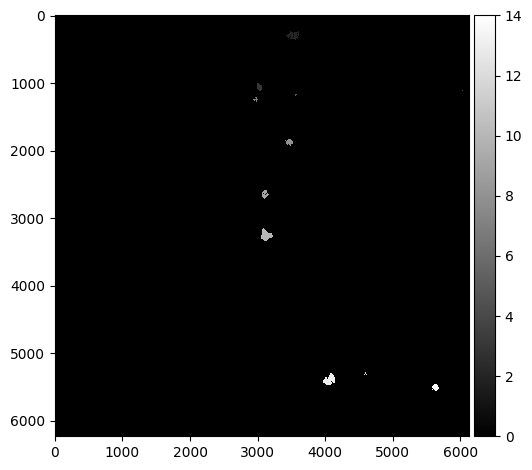

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_OA_Nocomp_02.czi
Green Channel


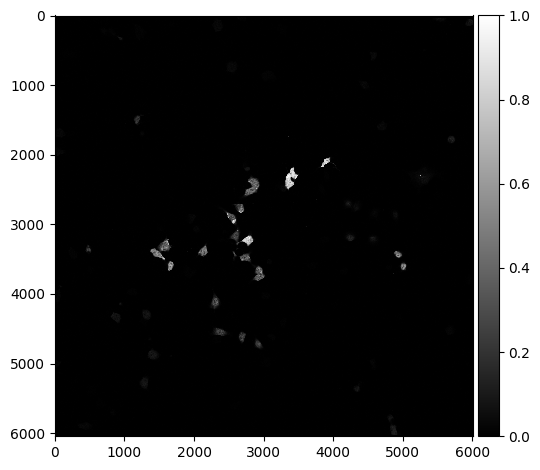

Number of cells:  42
Segmented Cells


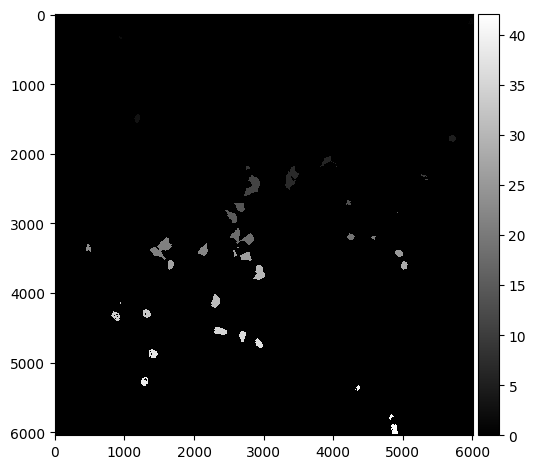

[18. 11. 42.]
[51.]


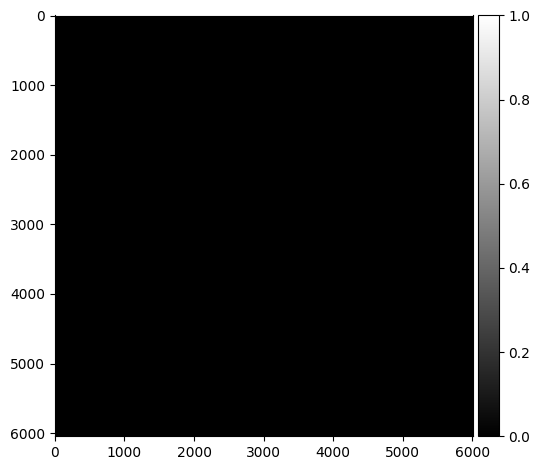

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [6]:
for i in range(len(folders)):
    analyze_all_images(folders[i])
